In [2]:
import torch
import torch.nn as nn

In [36]:
class RecConnection(nn.Module):
    def __init__(self,n):
        super(RecConnection,self).__init__()

        self.layer = nn.Linear(n,n)
    def forward(self, x):
        return self.layer(x)



In [39]:

n = 8
model = RecConnection(n)


# --- forward pass ---
x = torch.randn(n)

# Forward should fail because theta_pre is undefined
_ = model(x)

tensor([-0.8694, -0.1345, -0.7333, -0.5486,  1.0594,  0.4246, -0.2131,  0.3423],
       grad_fn=<ViewBackward0>)

# Hypere connection

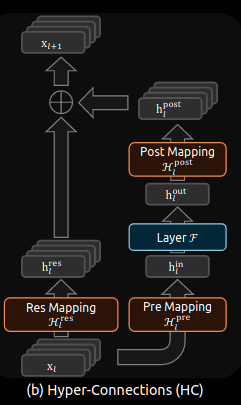

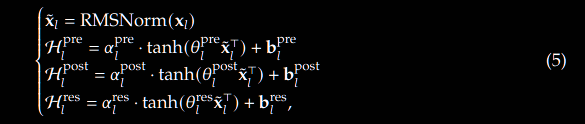

In [40]:
class HyperConnection(nn.Module):
    def __init__(self,n):
        super(HyperConnection,self).__init__()

        self.RMSnorm = nn.RMSNorm(n)

        self.theta_res = nn.Parameter(torch.ones(n))
        self.theta_pre = nn.Parameter(torch.ones(n))
        self.theta_post = nn.Parameter(torch.ones(n))

        self.alphaPer = nn.Parameter(torch.ones(n))
        self.alphaPost = nn.Parameter(torch.ones(n))
        self.alphaRes = nn.Parameter(torch.ones(n))

        self.betaPer = nn.Parameter(torch.ones(n))
        self.betaPost = nn.Parameter(torch.ones(n))
        self.betaRes = nn.Parameter(torch.ones(n))

        self.f = nn.Linear(n,n)
    def forward(self, x):

        xl = self.RMSnorm(x)
        Hl_pre =  torch.matmul(self.alphaPer, torch.matmul(self.theta_pre,xl.T)  + self.betaPer)
        Hl_res =  torch.matmul(self.alphaRes, torch.matmul(self.theta_res,xl.T)  + self.betaRes)
        Hl_out = self.f(Hl_pre)
        Hl_post = torch.matmul(self.alphaPost, torch.matmul(self.theta_post,Hl_out.T)  + self.betaPost)
        

        return Hl_post + Hl_res


In [42]:
_

tensor(-15.9524, grad_fn=<DotBackward0>)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def sinkhorn_knopp(W, iterations=20):
    """
    Projects a matrix onto the Birkhoff polytope (doubly stochastic manifold).
    Ensures rows and columns sum to 1[cite: 607].
    """
    # Start with a positive matrix by exponentiating the input [cite: 607]
    M = torch.exp(W)

    for _ in range(iterations):
        # Row normalization
        M = M / M.sum(dim=-1, keepdim=True)
        # Column normalization
        M = M / M.sum(dim=-2, keepdim=True)
    return M

In [45]:
class HyperConnection(nn.Module):
    def __init__(self, n, dim):
        super().__init__()
        self.n = n      # Expansion rate (number of streams)
        self.dim = dim  # Hidden dimension C

        # Mappings for pre-layer aggregation, post-layer distribution, and residual mixing
        self.theta_pre = nn.Parameter(torch.randn(1, dim))
        self.theta_post = nn.Parameter(torch.randn(1, dim))
        self.theta_res = nn.Parameter(torch.randn(n, dim))

        # Global biases and gating factors [cite: 887, 888]
        self.b_pre = nn.Parameter(torch.zeros(1, n))
        self.b_post = nn.Parameter(torch.zeros(1, n))
        self.b_res = nn.Parameter(torch.zeros(n, n))
        self.alpha = nn.Parameter(torch.ones(3) * 0.01) # Small initialization [cite: 890]

    def forward(self, x, layer_fn):
        # x shape: (batch, n, dim)
        x_norm = F.rms_norm(x, (self.dim,))

        # Compute dynamic mappings using tanh [cite: 887]
        h_pre = self.alpha[0] * torch.tanh(F.linear(x_norm, self.theta_pre)) + self.b_pre
        h_post = self.alpha[1] * torch.tanh(F.linear(x_norm, self.theta_post)) + self.b_post
        h_res = self.alpha[2] * torch.tanh(F.linear(x_norm, self.theta_res)) + self.b_res

        # 1. Read-out: Aggregate streams to single layer input [cite: 827]
        # (batch, 1, n) @ (batch, n, dim) -> (batch, 1, dim)
        layer_input = torch.bmm(h_pre, x)

        # 2. Layer Function: (e.g., Attention or FFN)
        layer_output = layer_fn(layer_input)

        # 3. Residual Mixing and Write-in [cite: 822]
        # Mix existing streams + Project layer output back to all streams
        res_part = torch.bmm(h_res, x)
        post_part = torch.bmm(h_post.transpose(-1, -2), layer_output)

        return res_part + post_part

In [46]:
class ManifoldConstrainedHC(nn.Module):
    def __init__(self, n, dim):
        super().__init__()
        self.n = n
        self.dim = dim

        # mHC uses flattened vector x_vec (n*dim) for its mappings [cite: 605]
        self.phi_pre = nn.Linear(n * dim, n)
        self.phi_post = nn.Linear(n * dim, n)
        self.phi_res = nn.Linear(n * dim, n * n)

        self.alpha = nn.Parameter(torch.ones(3) * 0.01)

    def forward(self, x, layer_fn):
        # Flatten x to n*dim vector [cite: 605]
        batch_size = x.shape[0]
        x_vec = x.view(batch_size, -1)
        x_vec_norm = F.rms_norm(x_vec, (self.n * self.dim,))

        # Compute dynamic mappings [cite: 606, 619]
        # Pre and Post use Sigmoid; Res uses Sinkhorn-Knopp
        h_pre = torch.sigmoid(self.alpha[0] * self.phi_pre(x_vec_norm)).unsqueeze(1)
        h_post = 2 * torch.sigmoid(self.alpha[1] * self.phi_post(x_vec_norm)).unsqueeze(1)

        h_res_raw = (self.alpha[2] * self.phi_res(x_vec_norm)).view(batch_size, self.n, self.n)
        h_res = sinkhorn_knopp(h_res_raw) # The "Manifold Constraint" [cite: 607]

        # Standard HC propagation logic with constrained weights [cite: 822]
        layer_input = torch.bmm(h_pre, x)
        layer_output = layer_fn(layer_input)

        return torch.bmm(h_res, x) + torch.bmm(h_post.transpose(-1, -2), layer_output)

In [47]:
import torch
import torch.nn as nn

def run_hc_test():
    # 1. Hyper-parameters
    batch_size = 2
    n_streams = 4    # 'n' in the paper
    hidden_dim = 16  # 'C' in the paper

    # 2. Create dummy input (Batch, Streams, Dimension)
    # Think of this as 4 parallel versions of the same sequence
    x = torch.randn(batch_size, n_streams, hidden_dim)

    # 3. Define a mock "Layer Function"
    # In a real model, this would be an Attention or FFN block.
    # It always processes a SINGLE stream (dim 1) and returns a SINGLE stream.
    layer = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim * 2),
        nn.ReLU(),
        nn.Linear(hidden_dim * 2, hidden_dim)
    )

    def layer_fn(tensor_in):
        # input shape: (batch, 1, dim)
        return layer(tensor_in)

    print(f"Input shape: {x.shape}")

    # --- Test 1: Standard HC ---
    print("\nTesting HC...")
    hc_module = HyperConnection(n=n_streams, dim=hidden_dim)
    output_hc = hc_module(x, layer_fn)
    print(f"HC Output shape: {output_hc.shape}")
    assert output_hc.shape == (batch_size, n_streams, hidden_dim)

    # --- Test 2: mHC (Manifold-Constrained) ---
    print("\nTesting mHC...")
    mhc_module = ManifoldConstrainedHC(n=n_streams, dim=hidden_dim)
    output_mhc = mhc_module(x, layer_fn)
    print(f"mHC Output shape: {output_mhc.shape}")
    assert output_mhc.shape == (batch_size, n_streams, hidden_dim)

    # --- Test 3: Verify the "Manifold" Property ---
    # We check if Sinkhorn-Knopp actually produces a doubly stochastic matrix
    print("\nVerifying Manifold Constraint (Sinkhorn-Knopp)...")
    test_weights = torch.randn(1, n_streams, n_streams)
    ds_matrix = sinkhorn_knopp(test_weights)

    row_sums = ds_matrix.sum(dim=-1)
    col_sums = ds_matrix.sum(dim=-2)

    print(f"Row sums (should be 1.0): {row_sums.detach().numpy()}")
    print(f"Col sums (should be 1.0): {col_sums.detach().numpy()}")

    # Use torch.allclose to allow for tiny floating point errors
    assert torch.allclose(row_sums, torch.ones_like(row_sums))
    assert torch.allclose(col_sums, torch.ones_like(col_sums))

    print("\nAll tests passed successfully!")

if __name__ == "__main__":
    run_hc_test()

Input shape: torch.Size([2, 4, 16])

Testing HC...
HC Output shape: torch.Size([2, 4, 16])

Testing mHC...
mHC Output shape: torch.Size([2, 4, 16])

Verifying Manifold Constraint (Sinkhorn-Knopp)...
Row sums (should be 1.0): [[1. 1. 1. 1.]]
Col sums (should be 1.0): [[1. 1. 1. 1.]]

All tests passed successfully!
